In [1]:
# !pip install pandas scikit-learn xgboost matplotlib seaborn joblib

import os
import sys
import importlib

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, log_loss, top_k_accuracy_score
from sklearn.model_selection import train_test_split

sns.set_theme(style="whitegrid")


# Product Recommender Reload
This notebook mirrors `src/train_recommender.py`: it loads the Google Sheets data, builds the RFM-enhanced feature set, trains the tuned RandomForest pipeline, and inspects evaluation metrics and sample predictions.


In [2]:
# Load Google Sheets data and train via the shared pipeline
sys.path.insert(0, os.path.abspath('..'))
import src.train_recommender as tr
importlib.reload(tr)

social_url = "https://docs.google.com/spreadsheets/d/1nljJ7XmuYEyqJOkyg_NH5EYcThQyGz-8ScoQRiyDST8/export?format=csv"
transactions_url = "https://docs.google.com/spreadsheets/d/1oyJFciFnlS0ueOg8wQaANRp1JOy8JdbCcglAtVEYcVM/export?format=csv"

print("Loading transactions and social CSVs via train_recommender helpers...")
tx = tr.load_csv(transactions_url)
so = tr.load_csv(social_url)
print("Transactions shape:", tx.shape)
print("Social shape:", so.shape)

print("\nMerging datasets...")
merged = tr.build_dataset(tx, so)
print("Merged shape:", merged.shape)

print("\nComputing customer aggregates (RFM) when possible...")
cust_keys = [c for c in tx.columns if 'customer' in c.lower() or 'id' in c.lower()]
date_candidates = [c for c in tx.columns if any(k in c.lower() for k in ['date', 'time', 'created'])]
amount_candidates = [c for c in tx.columns if any(k in c.lower() for k in ['amount', 'price', 'total', 'value'])]
if cust_keys and date_candidates and amount_candidates:
    ck = cust_keys[0]
    dtc = date_candidates[0]
    amt = amount_candidates[0]
    try:
        tx[dtc] = pd.to_datetime(tx[dtc], errors='coerce')
        snapshot = tx[dtc].max()
        rfm = tx.groupby(ck).agg(
            recency_days=(dtc, lambda s: (snapshot - s.max()).days if pd.notnull(s.max()) else 9999),
            frequency=(dtc, 'count'),
            monetary=(amt, 'sum')
        ).reset_index()
        product_cols = [c for c in tx.columns if any(k in c.lower() for k in ['product', 'item', 'sku'])]
        if product_cols:
            pcol = product_cols[0]
            prod_counts = tx.groupby(ck)[pcol].nunique().reset_index().rename(columns={pcol: 'unique_product_count'})
            last_prod = tx.sort_values(dtc).groupby(ck)[pcol].last().reset_index().rename(columns={pcol: 'last_product'})
            rfm = rfm.merge(prod_counts, on=ck, how='left')
            rfm = rfm.merge(last_prod, on=ck, how='left')
        merge_keys = [c for c in merged.columns if ck.lower() in c.lower() or 'customer' in c.lower()]
        if merge_keys:
            mk = merge_keys[0]
            merged = merged.merge(rfm, left_on=mk, right_on=ck, how='left')
        else:
            merged = merged.merge(rfm, left_on=ck, right_on=ck, how='left')
        added_cols = [c for c in ['recency_days', 'frequency', 'monetary', 'unique_product_count', 'last_product'] if c in merged.columns]
        print('RFM merged. Added columns:', added_cols)
    except Exception as exc:
        print('RFM computation failed:', exc)
else:
    print('RFM not computed: missing customer/date/amount fields.')

print("\nRunning training with hyperparameter tuning enabled...")
results, model_path, pipeline_path = tr.preprocess_and_train(merged, tune=True)

results_df = pd.DataFrame(results).T.sort_values('f1_weighted', ascending=False)
print("\nTraining results (sorted by weighted F1):")
display(results_df)

print("Saved model:", model_path)
print("Saved pipeline:", pipeline_path)


Loading transactions and social CSVs via train_recommender helpers...
Transactions shape: (150, 6)
Social shape: (155, 5)

Merging datasets...
Merged shape: (150, 11)

Computing customer aggregates (RFM) when possible...
RFM merged. Added columns: ['recency_days', 'frequency', 'monetary', 'unique_product_count', 'last_product']

Running training with hyperparameter tuning enabled...
Running RandomizedSearchCV for RandomForest (lightweight)...
Transactions shape: (150, 6)
Social shape: (155, 5)

Merging datasets...
Merged shape: (150, 11)

Computing customer aggregates (RFM) when possible...
RFM merged. Added columns: ['recency_days', 'frequency', 'monetary', 'unique_product_count', 'last_product']

Running training with hyperparameter tuning enabled...
Running RandomizedSearchCV for RandomForest (lightweight)...
RandomizedSearchCV RF best params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
RandomizedSearchCV RF best p

/Users/apple/Documents/Formative-2-Data-Processing/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [11:07:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Training results (sorted by weighted F1):


,accuracy,f1_weighted,log_loss,top3
rf,0.566667,0.525289,1.354045,0.833333
lr,0.533333,0.491111,1.338988,0.866667
xgb,0.433333,0.433333,2.153597,0.900000


Saved model: /Users/apple/Documents/Formative-2-Data-Processing/models/product_recommender.pkl
Saved pipeline: /Users/apple/Documents/Formative-2-Data-Processing/models/recommender_pipeline.pkl


Recomputed metrics: {'accuracy': 0.5666666666666667, 'f1_weighted': 0.5252890899949724, 'log_loss': 1.3540450045892605, 'top3': 0.8333333333333334}

Classification report (RandomForest best model):
              precision    recall  f1-score   support

       Books       0.75      0.60      0.67         5
    Clothing       0.56      0.83      0.67         6
 Electronics       0.67      0.57      0.62         7
   Groceries       0.00      0.00      0.00         5
      Sports       0.50      0.71      0.59         7

    accuracy                           0.57        30
   macro avg       0.49      0.54      0.51        30
weighted avg       0.51      0.57      0.53        30



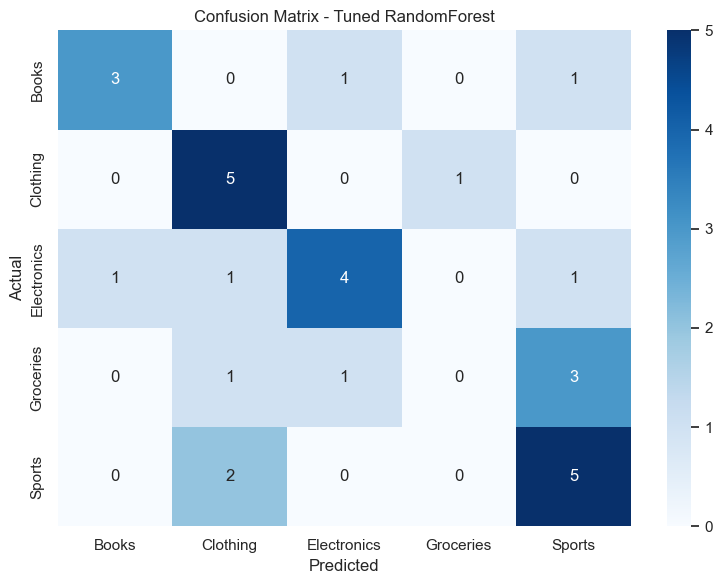

In [3]:
# Evaluate the persisted pipeline on the deterministic test split
bundle = joblib.load(pipeline_path)
feature_columns = bundle['feature_columns']
preprocessor = bundle['preprocessor']
model = bundle['model']
label_encoder = bundle['label_encoder']

target_col = 'product_category'
merged_eval = merged.dropna(subset=[target_col]).copy()
y_raw = merged_eval[target_col].astype(str)
y_all = label_encoder.transform(y_raw)
X_all = merged_eval[feature_columns]

X_train_raw, X_test_raw, y_train_all, y_test_all = train_test_split(
    X_all,
    y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)

X_test = preprocessor.transform(X_test_raw)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

metrics = {
    'accuracy': accuracy_score(y_test_all, y_pred),
    'f1_weighted': f1_score(y_test_all, y_pred, average='weighted'),
    'log_loss': log_loss(y_test_all, y_proba),
    'top3': top_k_accuracy_score(y_test_all, y_proba, k=3)
}
print('Recomputed metrics:', metrics)

print('\nClassification report (RandomForest best model):')
print(classification_report(
    label_encoder.inverse_transform(y_test_all),
    label_encoder.inverse_transform(y_pred)
))

cm = confusion_matrix(y_test_all, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Confusion Matrix - Tuned RandomForest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Persist context for downstream sampling
evaluation_context = {
    'bundle': bundle,
    'X_test_raw': X_test_raw.reset_index(drop=True),
    'y_test_all': y_test_all,
}


In [7]:
def recommend_product(bundle, customer_features: dict):
    """Generate a product recommendation for a single customer feature dict."""
    feature_columns = bundle['feature_columns']
    missing = [c for c in feature_columns if c not in customer_features]
    if missing:
        raise ValueError(f"Missing features for inference: {missing}")

    input_df = pd.DataFrame([customer_features])[feature_columns]

    # Ensure categorical features remain strings (OneHotEncoder expects same dtype)
    categorical_cols = []
    for name, transformer, columns in bundle['preprocessor'].transformers_:
        if name == 'cat':
            categorical_cols.extend(columns)
    for col in categorical_cols:
        if col in input_df.columns:
            input_df[col] = input_df[col].astype(str)

    transformed = bundle['preprocessor'].transform(input_df)
    proba = bundle['model'].predict_proba(transformed)[0]
    pred_idx = int(np.argmax(proba))
    predicted_category = bundle['label_encoder'].inverse_transform([pred_idx])[0]
    probabilities = {
        cls: float(prob)
        for cls, prob in zip(bundle['label_encoder'].classes_, proba)
    }
    return predicted_category, probabilities


In [5]:
feature_columns = evaluation_context['bundle']['feature_columns']
print(f"Total feature columns: {len(feature_columns)}")
print(feature_columns)


Total feature columns: 11
['purchase_amount', 'engagement_score', 'purchase_interest_score', 'recency_days', 'frequency', 'monetary', 'unique_product_count', 'purchase_date', 'social_media_platform', 'review_sentiment', 'last_product']


In [8]:
bundle = evaluation_context['bundle']
X_test_raw = evaluation_context['X_test_raw']
y_test_all = evaluation_context['y_test_all']
label_encoder = bundle['label_encoder']

sample_idx = 0
sample_features = X_test_raw.iloc[sample_idx].to_dict()
predicted_label, probabilities = recommend_product(bundle, sample_features)
actual_label = label_encoder.inverse_transform([y_test_all[sample_idx]])[0]

print(f"Sample {sample_idx} actual label: {actual_label}")
print(f"Sample {sample_idx} predicted label: {predicted_label}")
display(pd.Series(probabilities).sort_values(ascending=False).head(5))


Sample 0 actual label: Groceries
Sample 0 predicted label: Sports


Sports         0.439671
Books          0.212976
Groceries      0.141851
Electronics    0.120090
Clothing       0.085413
dtype: float64

In [9]:
for idx in range(3):
    sample = X_test_raw.iloc[idx].to_dict()
    predicted_label, probabilities = recommend_product(bundle, sample)
    actual_label = label_encoder.inverse_transform([y_test_all[idx]])[0]
    print(f"Sample {idx}: actual={actual_label} | predicted={predicted_label}")
    top_probs = pd.Series(probabilities).sort_values(ascending=False).head(3)
    print(top_probs.to_string())
    print('-' * 60)


Sample 0: actual=Groceries | predicted=Sports
Sports       0.439671
Books        0.212976
Groceries    0.141851
------------------------------------------------------------
Sample 1: actual=Clothing | predicted=Clothing
Clothing       0.708698
Electronics    0.117267
Groceries      0.077054
------------------------------------------------------------
Sample 2: actual=Sports | predicted=Sports
Sports         0.458775
Electronics    0.261425
Groceries      0.132729
------------------------------------------------------------
